### 📦 Import libraries

In [17]:
# Built-in libraries
import os
from collections import defaultdict

# Third-party libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D,
    LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)


### 📂 Load and parse image dataset

In [18]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Applications/Tien/deepfake-models/frequency


In [3]:
# Đường dẫn dataset và nhãn
base_path = '/Applications/Tien/deepfake/Dataset/celeb_df_crop'
categories = ['fake', 'real']

data = []

# Duyệt qua từng ảnh trong thư mục fake/real
for label in categories:
    folder_path = os.path.join(base_path, label)
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jpg'):
            continue
        try:
            id_part, frame_part = filename.split('_frame_')
            sample_id = int(id_part.split('_')[0])
            frame_idx = int(frame_part.split('.')[0])
            data.append({
                'filename': filename,
                'path': os.path.join(folder_path, filename),
                'id': sample_id,
                'frame': frame_idx,
                'label': label
            })
        except ValueError:
            # Bỏ qua ảnh sai định dạng
            continue

# Chuyển về DataFrame
df = pd.DataFrame(data)


In [4]:
df

,filename,path,id,frame,label
0,222_id32_0007_frame_0028.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,222,28,fake
1,522_id7_0003_frame_0027.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,522,27,fake
2,501_id60_0007_frame_0022.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,501,22,fake
3,487_id59_0008_frame_0023.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,487,23,fake
4,239_id34_0004_frame_0007.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,239,7,fake
...,...,...,...,...,...
32367,082_id1_0001_frame_0027.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,82,27,real
32368,186_id2_0001_frame_0007.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,186,7,real
32369,200_id30_0005_frame_0014.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,200,14,real
32370,460_id56_0007_frame_0012.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,460,12,real


### 🔁 Encode label

In [5]:
# Chuyển nhãn về số: fake=0, real=1
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})


### 🎞️ Group frames by video

In [6]:
# Tạo khóa duy nhất cho mỗi video dựa trên id và nhãn
df['video_key'] = df['id'].astype(str) + "_" + df['label']

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


### 🏷️ Check label dictionary

In [7]:
labels  # Kiểm tra dict chứa nhãn video

{'222_fake': 0,
 '522_fake': 0,
 '501_fake': 0,
 '487_fake': 0,
 '239_fake': 0,
 '433_fake': 0,
 '35_fake': 0,
 '133_fake': 0,
 '297_fake': 0,
 '77_fake': 0,
 '363_fake': 0,
 '117_fake': 0,
 '234_fake': 0,
 '5_fake': 0,
 '474_fake': 0,
 '89_fake': 0,
 '282_fake': 0,
 '27_fake': 0,
 '372_fake': 0,
 '402_fake': 0,
 '208_fake': 0,
 '482_fake': 0,
 '115_fake': 0,
 '445_fake': 0,
 '458_fake': 0,
 '70_fake': 0,
 '200_fake': 0,
 '82_fake': 0,
 '186_fake': 0,
 '112_fake': 0,
 '354_fake': 0,
 '6_fake': 0,
 '193_fake': 0,
 '448_fake': 0,
 '538_fake': 0,
 '167_fake': 0,
 '10_fake': 0,
 '38_fake': 0,
 '211_fake': 0,
 '460_fake': 0,
 '176_fake': 0,
 '511_fake': 0,
 '57_fake': 0,
 '524_fake': 0,
 '396_fake': 0,
 '0_fake': 0,
 '320_fake': 0,
 '491_fake': 0,
 '244_fake': 0,
 '95_fake': 0,
 '308_fake': 0,
 '481_fake': 0,
 '300_fake': 0,
 '443_fake': 0,
 '154_fake': 0,
 '67_fake': 0,
 '252_fake': 0,
 '492_fake': 0,
 '385_fake': 0,
 '3_fake': 0,
 '382_fake': 0,
 '311_fake': 0,
 '237_fake': 0,
 '272_fake'

In [8]:
!pip install opencv-python

In [12]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, TimeDistributed, LSTM, Dropout, Dense,
                                     GlobalAveragePooling2D, BatchNormalization,
                                     Bidirectional, Conv2D, MaxPooling2D, Concatenate)  # === ✨ CHANGED: thêm Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# from hmmlearn.hmm import GaussianHMM  # === ✨ CHANGED: BỎ HMM
# from scipy.stats import mode          # === ✨ CHANGED: BỎ mode

# Giả định đã có
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 16
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# === ✨ CHANGED BLOCK: tiện ích xử lý tần số (DCT)
def dct_logmag_gray(img_rgb_uint8, out_size):
    """
    img_rgb_uint8: ảnh RGB uint8 (H,W,3)
    Trả về ảnh tần số dạng (out_size[0], out_size[1], 1) float32 đã chuẩn hóa [0,1]
    """
    # RGB -> Gray
    gray = cv2.cvtColor(img_rgb_uint8, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, out_size)
    # DCT 2D (cv2.dct yêu cầu float32)
    dct = cv2.dct(gray.astype(np.float32))
    dct = np.abs(dct)
    dct = np.log1p(dct)  # nén động
    # Chuẩn hóa per-frame về [0,1]
    mn, mx = dct.min(), dct.max()
    if mx > mn:
        dct_norm = (dct - mn) / (mx - mn)
    else:
        dct_norm = np.zeros_like(dct, dtype=np.float32)
    return dct_norm[..., None].astype(np.float32)

# Data generator (dual-branch: không gian + tần số)
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        # === ✨ CHANGED: bỏ rescale vì ta dùng preprocess_input cho MobileNet
        self.datagen = ImageDataGenerator(
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_rgb, batch_X_freq, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            rgbs, freqs = [], []

            for path in frames:
                # === ✨ CHANGED: chuẩn RGB + augment + preprocess_input
                bgr = cv2.imread(path)
                if bgr is None:
                    continue  # bỏ frame lỗi
                rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
                rgb = cv2.resize(rgb, self.img_size)

                if self.augment:
                    rgb = self.datagen.random_transform(rgb)

                # Nhánh tần số tính từ ảnh RGB đã resize/augment
                freq = dct_logmag_gray(rgb, self.img_size)   # (H,W,1) float32 0..1

                # MobileNetV2 preprocess ([-1,1])
                rgb_pp = tf.keras.applications.mobilenet_v2.preprocess_input(rgb.astype('float32'))

                rgbs.append(rgb_pp)
                freqs.append(freq)

            # === ✨ CHANGED: padding lặp frame cuối để tránh "khung đen"
            if len(rgbs) == 0:
                # nếu video không đọc được frame nào, bỏ qua mẫu
                continue
            while len(rgbs) < self.sequence_len:
                rgbs.append(rgbs[-1])
                freqs.append(freqs[-1])

            batch_X_rgb.append(rgbs[:self.sequence_len])
            batch_X_freq.append(freqs[:self.sequence_len])
            batch_y.append(self.labels[key])

        # === ✨ CHANGED: trả về 2 inputs [RGB, FREQ]
        return [np.array(batch_X_rgb, dtype=np.float32),
                np.array(batch_X_freq, dtype=np.float32)], np.array(batch_y, dtype=np.int32)

# === ✨ CHANGED BLOCK: model dual-branch (spatial + frequency)
def build_model(sequence_len, img_size):
    # Nhánh không gian: MobileNetV2 pretrained
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = False  # warmup
    spatial_feat = GlobalAveragePooling2D()(base_cnn.output)
    spatial_model = Model(inputs=base_cnn.input, outputs=spatial_feat, name="spatial_backbone")

    # Nhánh tần số: CNN nhẹ trên đầu vào (H,W,1)
    freq_in = Input(shape=(*img_size, 1))
    x = Conv2D(16, 3, padding='same', activation='relu')(freq_in)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    freq_model = Model(inputs=freq_in, outputs=x, name="frequency_backbone")

    # Inputs chuỗi
    input_seq_rgb = Input(shape=(sequence_len, *img_size, 3), name="input_rgb_seq")
    input_seq_freq = Input(shape=(sequence_len, *img_size, 1), name="input_freq_seq")

    # TimeDistributed cho từng nhánh
    td_spatial = TimeDistributed(spatial_model, name="td_spatial")(input_seq_rgb)
    td_freq    = TimeDistributed(freq_model,    name="td_frequency")(input_seq_freq)

    # Hợp nhất đặc trưng theo frame
    fused = Concatenate(name="concat_frame_feats")([td_spatial, td_freq])

    # LSTM chuỗi đặc trưng đã hợp nhất
    x = LSTM(64, return_sequences=False, name="seq_lstm")(fused)
    x = Dropout(0.5)(x)

    output = Dense(1, activation='sigmoid', name="output")(x)

    model = Model(inputs=[input_seq_rgb, input_seq_freq], outputs=output, name="dual_branch_dct_model")
    return model

# Training K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen   = VideoSequence(val_keys,   video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen  = VideoSequence(test_keys,  video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size)
    model.compile(optimizer=Adamax(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    model_path = f"best_model_fold{fold}.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop  = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    # === ✨ CHANGED: bỏ HMM, dự đoán trực tiếp
    y_pred_prob = model.predict(test_gen).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })

print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====


Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.5244
Epoch 1: val_accuracy improved from -inf to 0.51724, saving model to best_model_fold1.h5
49/49 [==============================] - 112s 2s/step - loss: 0.7292 - accuracy: 0.5244 - val_loss: 0.6982 - val_accuracy: 0.5172 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.5615
Epoch 2: val_accuracy improved from 0.51724 to 0.59770, saving model to best_model_fold1.h5
49/49 [==============================] - 154s 3s/step - loss: 0.6794 - accuracy: 0.5615 - val_loss: 0.6801 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.5718
Epoch 3: val_accuracy did not improve from 0.59770
49/49 [==============================] - 145s 3s/step - loss: 0.6737 - accuracy: 0.5718 - val_loss: 0.6839 - val_accuracy: 0.5632 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.6321
Epoch 4: val_accuracy improved from 0.59770 to 0.60920, saving model to best_model_fold1.h5
49/49 [==============================] - 139s 3s/step - loss: 0.6505 - accuracy: 0.6321 - val_loss: 0.6717 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 5/50
49/49 [==============================] - E

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.7003 - accuracy: 0.5423
Epoch 1: val_accuracy improved from -inf to 0.59770, saving model to best_model_fold2.h5
49/49 [==============================] - 142s 3s/step - loss: 0.7003 - accuracy: 0.5423 - val_loss: 0.6716 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.5962
Epoch 2: val_accuracy improved from 0.59770 to 0.60920, saving model to best_model_fold2.h5
49/49 [==============================] - 143s 3s/step - loss: 0.6672 - accuracy: 0.5962 - val_loss: 0.6493 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.6064
Epoch 3: val_accuracy improved from 0.60920 to 0.62069, saving model to best_model_fold2.h5
49/49 [==============================] - 147s 3s/step - loss: 0.6499 - accuracy: 0.6064 - val_loss: 0.6403 - val_accuracy: 0.6207 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.6244
Epoch 4: val_accuracy did not improve from 0.62069
49/49 [==============================] - 145s 3s/step - loss: 0.6333 - accuracy: 0.6244 - val_loss: 0.6298 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 5/50
49/49 [==============================] - E

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.5205
Epoch 1: val_accuracy improved from -inf to 0.56322, saving model to best_model_fold3.h5
49/49 [==============================] - 139s 3s/step - loss: 0.7031 - accuracy: 0.5205 - val_loss: 0.6765 - val_accuracy: 0.5632 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.5744
Epoch 2: val_accuracy improved from 0.56322 to 0.59770, saving model to best_model_fold3.h5
49/49 [==============================] - 143s 3s/step - loss: 0.6762 - accuracy: 0.5744 - val_loss: 0.6656 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6623 - accuracy: 0.5962
Epoch 3: val_accuracy did not improve from 0.59770
49/49 [==============================] - 137s 3s/step - loss: 0.6623 - accuracy: 0.5962 - val_loss: 0.6553 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.6410
Epoch 4: val_accuracy improved from 0.59770 to 0.60920, saving model to best_model_fold3.h5
49/49 [==============================] - 138s 3s/step - loss: 0.6348 - accuracy: 0.6410 - val_loss: 0.6505 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 5/50
49/49 [==============================] - E

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.7157 - accuracy: 0.5410
Epoch 1: val_accuracy improved from -inf to 0.62069, saving model to best_model_fold4.h5
49/49 [==============================] - 136s 3s/step - loss: 0.7157 - accuracy: 0.5410 - val_loss: 0.6679 - val_accuracy: 0.6207 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.5987
Epoch 2: val_accuracy did not improve from 0.62069
49/49 [==============================] - 154s 3s/step - loss: 0.6730 - accuracy: 0.5987 - val_loss: 0.6569 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.5987
Epoch 3: val_accuracy improved from 0.62069 to 0.64368, saving model to best_model_fold4.h5
49/49 [==============================] - 149s 3s/step - loss: 0.6599 - accuracy: 0.5987 - val_loss: 0.6496 - val_accuracy: 0.6437 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.5833
Epoch 4: val_accuracy did not improve from 0.64368
49/49 [==============================] - 141s 3s/step - loss: 0.6592 - accuracy: 0.5833 - val_loss: 0.6459 - val_accuracy: 0.6437 - lr: 1.0000e-04
Epoch 5/50
49/49 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.6346


Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.5058
Epoch 1: val_accuracy improved from -inf to 0.50575, saving model to best_model_fold5.h5
49/49 [==============================] - 139s 3s/step - loss: 0.7221 - accuracy: 0.5058 - val_loss: 0.6891 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.5403
Epoch 2: val_accuracy improved from 0.50575 to 0.58621, saving model to best_model_fold5.h5
49/49 [==============================] - 135s 3s/step - loss: 0.7040 - accuracy: 0.5403 - val_loss: 0.6762 - val_accuracy: 0.5862 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5570
Epoch 3: val_accuracy improved from 0.58621 to 0.59770, saving model to best_model_fold5.h5
49/49 [==============================] - 134s 3s/step - loss: 0.6856 - accuracy: 0.5570 - val_loss: 0.6661 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.6069
Epoch 4: val_accuracy improved from 0.59770 to 0.62069, saving model to best_model_fold5.h5
49/49 [==============================] - 141s 3s/step - loss: 0.6538 - accuracy: 0.6069 - val_loss: 0.6574 - val_accuracy: 0.6207 - lr: 1.0000e-04
Epoch 5/50
4

In [13]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.661452
precision    0.712452
recall       0.558885
f1           0.617488
auc          0.738292
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.677419,0.706522,0.601852,0.650000,0.768603
1,2,0.603687,0.671875,0.398148,0.500000,0.678220
2,3,0.691244,0.828125,0.486239,0.612717,0.769538
3,4,0.658986,0.644628,0.715596,0.678261,0.707866
4,5,0.675926,0.711111,0.592593,0.646465,0.767233


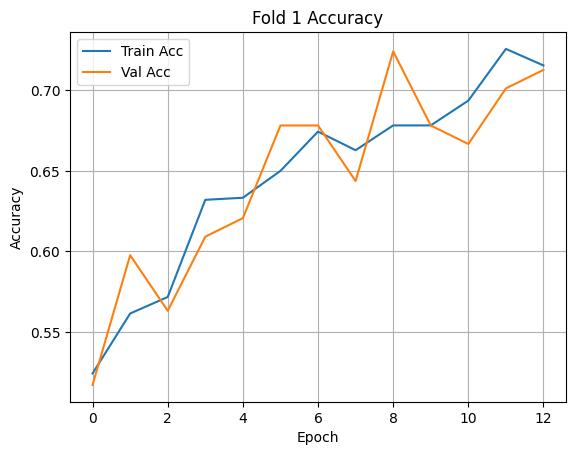

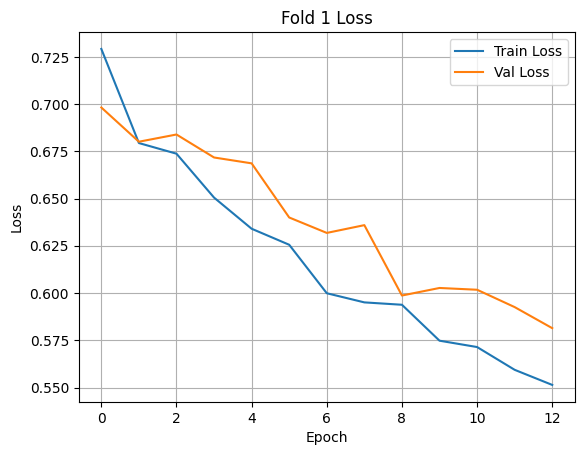

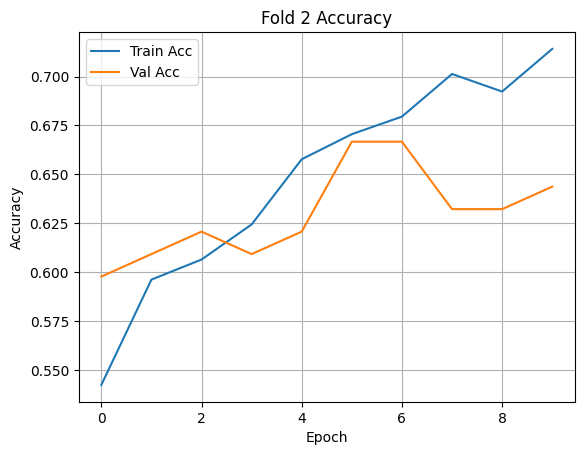

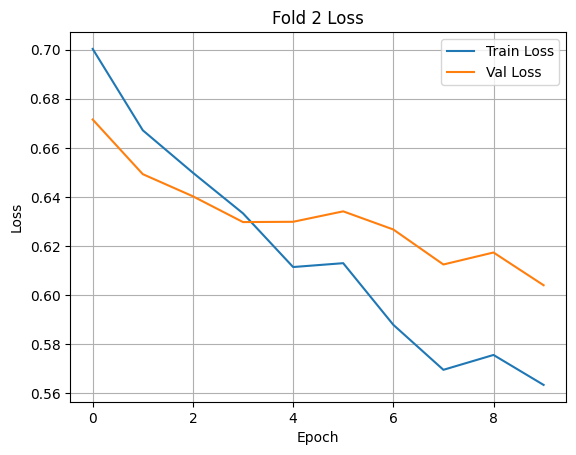

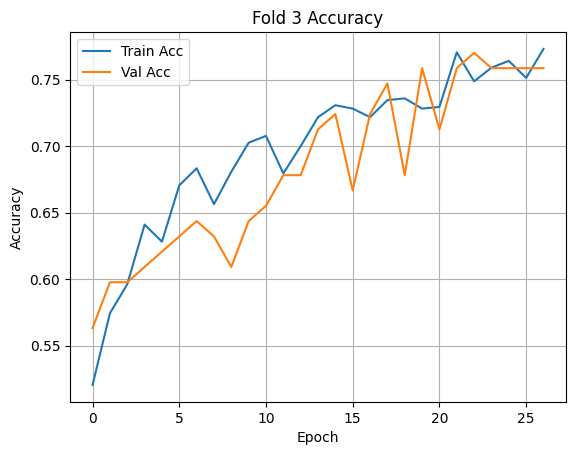

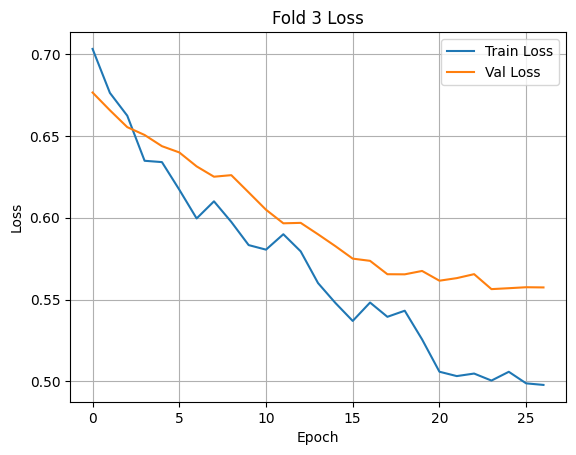

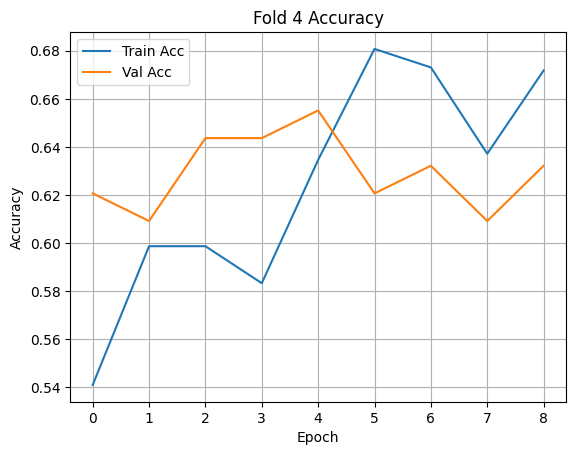

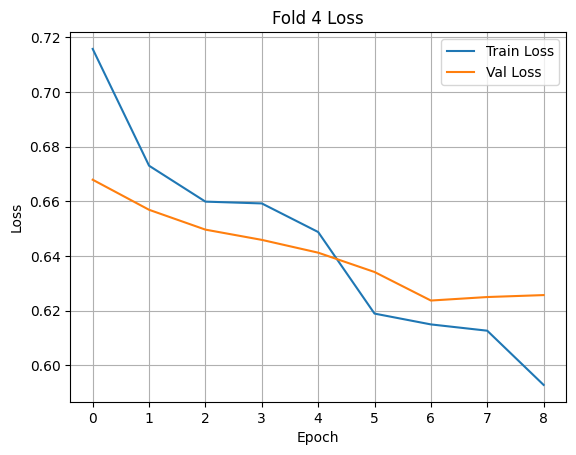

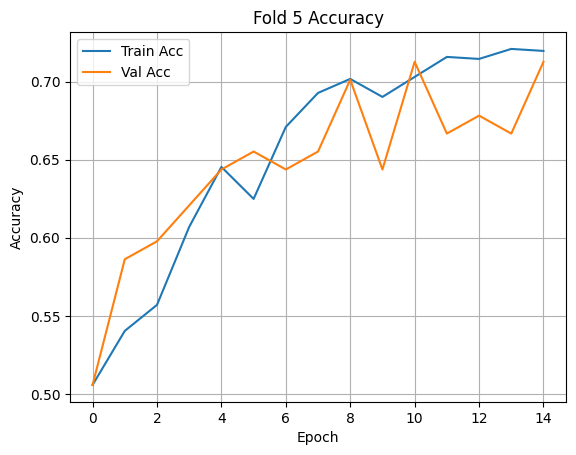

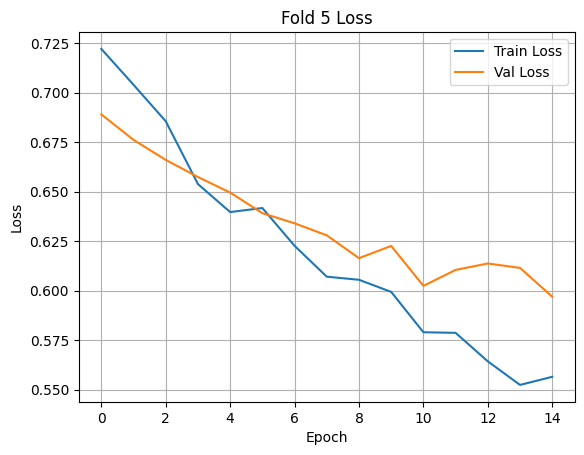

In [14]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_faceplus_final.h5")


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.661452
precision    0.712452
recall       0.558885
f1           0.617488
auc          0.738292
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.6615
📈 Range Accuracy: 0.0876
📉 Accuracy CV% (std/mean): 5.18%


,fold,accuracy,precision,recall,f1,auc
0,1,0.677419,0.706522,0.601852,0.650000,0.768603
1,2,0.603687,0.671875,0.398148,0.500000,0.678220
2,3,0.691244,0.828125,0.486239,0.612717,0.769538
3,4,0.658986,0.644628,0.715596,0.678261,0.707866
4,5,0.675926,0.711111,0.592593,0.646465,0.767233
